필수
- 데이터프레임 결측치와 데이터 타입 확인 및 처리<br>
- 레그플롯과 박스 플롯을 통한 이상치 확인<br>
- 기술통계 및 도수분포표를 통한 이상치 확인 및 제거<br>
- 이상치 제거 후 레그플롯으로 확인<br>
- 스케일링 전 신뢰구간 확인 후 시각화<br>
- 정규분포가정(정규성 검정 대체)<br>
- 표준화-정규화(scaling)<br>
- 주성분 분석(PCA)<br>
- 상관분석<br>
- 회귀분석<br>
- 분석 결과 그래프 및 차트 제시

사용할 분석방법 후보
- 피어슨 상관분석, 회귀분석(단순회귀,다중회귀), 로지스틱 등

귀무가설: 총생활비와 y값의 상관이 없다.<br>
대립가설: 총생활비는 y값과 상관이 있다.

패키지 준비

In [1]:
from pandas import read_excel, DataFrame, merge, cut
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy import stats
import seaborn as sb
import numpy as np
from patsy import dmatrix
import sys
import os
from scipy.stats import shapiro, normaltest, ks_2samp, bartlett, fligner, levene, chi2_contingency,t
import statsmodels.api as sm
from math import sqrt
# 주성분 분석용 패키지
from sklearn.decomposition import PCA
# 주성분 분석 결과를 DataFrame으로 확인할 수 있는 기능을 제공하는 패키지
from pca import pca

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from helper import myOls, getConfidenceInterval, pearson_r, spearman_r

그래프 초기화

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

# #데이터 준비

In [3]:
# 데이터 준비
df=read_excel("세미프로젝트3.xlsx")
df

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


In [4]:
#원본 데이터 유지하기 위해 카피본 생성
df1=df.copy()

In [5]:
#각 변수 데이터타입 확인하기
df1.dtypes

총생활비             int64
이자_배당금_연간소득    float64
임대료_연간소득         int64
기타_소득          float64
세금환급금          float64
금융기관대출           int64
주거관련_부채의_이자      int64
주택관련_부채액       float64
공적연금_연간소득        int64
dtype: object

for문으로 컬럼 돌려서 수치가 0인값, 0이 아닌 값 확인

In [6]:
for column in df1.columns:
    zero_count = df1.loc[df1[column] == 0].shape[0]
    number_count = df1.loc[df1[column] != 0].shape[0]
    print('0 개수 :',{column : zero_count})
    print('0 아닌 수 :',{column : number_count})
    print('-'*30)

0 개수 : {'총생활비': 0}
0 아닌 수 : {'총생활비': 7865}
------------------------------
0 개수 : {'이자_배당금_연간소득': 5489}
0 아닌 수 : {'이자_배당금_연간소득': 2376}
------------------------------
0 개수 : {'임대료_연간소득': 6707}
0 아닌 수 : {'임대료_연간소득': 1158}
------------------------------
0 개수 : {'기타_소득': 1439}
0 아닌 수 : {'기타_소득': 6426}
------------------------------
0 개수 : {'세금환급금': 6275}
0 아닌 수 : {'세금환급금': 1590}
------------------------------
0 개수 : {'금융기관대출': 5500}
0 아닌 수 : {'금융기관대출': 2365}
------------------------------
0 개수 : {'주거관련_부채의_이자': 6414}
0 아닌 수 : {'주거관련_부채의_이자': 1451}
------------------------------
0 개수 : {'주택관련_부채액': 5342}
0 아닌 수 : {'주택관련_부채액': 2523}
------------------------------
0 개수 : {'공적연금_연간소득': 4777}
0 아닌 수 : {'공적연금_연간소득': 3088}
------------------------------


## #이상치/결측치 확인 및 처리

- 종속변수
    - 총생활비

- 독립변수
    - '이자_배당금_연간소득','임대료_연간소득','기타_소득','세금환급금'
    - '금융기관대출', '주거관련_부채의_이자','주택관련_부채액','공적연금_연간소득'

- 불로소득에 포함되는 변수
    - 이자_배당금_연간소득, 임대료_연간소득, 공적연금_연간소득,세금환급금

- 부채에 포함되는 변수
    - 금융기관대출, 주거관련_부채의_이자, 주택관련_부채액

In [7]:
df1.head()

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0


In [8]:
# 결측치 확인
df1.isna().sum()

총생활비              0
이자_배당금_연간소득       0
임대료_연간소득          0
기타_소득             0
세금환급금             0
금융기관대출            0
주거관련_부채의_이자       0
주택관련_부채액       1079
공적연금_연간소득         0
dtype: int64

주택관련_부채액 결측치 1079건의 데이터 값을 '0'으로 간주하고 대체

In [9]:
re_df1=df1.fillna(value=0)
re_df1

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


결측치 수정 확인

In [10]:
re_df1.isna().sum()

총생활비           0
이자_배당금_연간소득    0
임대료_연간소득       0
기타_소득          0
세금환급금          0
금융기관대출         0
주거관련_부채의_이자    0
주택관련_부채액       0
공적연금_연간소득      0
dtype: int64

## #기초통계량으로 데이터의 전체적 특징 확인

In [11]:
re_df1.describe().round(3)

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
count,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000
mean,329.822,55.538,129.336,8.456,14.506,2958.797,53.392,1773.448,288.639
std,1314.994,347.927,644.463,87.830,59.831,8277.347,195.466,5527.462,675.031
min,23.000,0.000,0.000,0.000,-700.000,0.000,0.000,0.000,0.000
25%,121.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
50%,228.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000,0.000
75%,435.000,20.000,0.000,8.000,0.000,1700.000,0.000,0.000,288.000
max,114446.000,22025.000,17640.000,5506.000,1000.000,200000.000,7200.000,120000.000,8796.000


확인 결과 각 컬럼별 평균치에 비해 max값이 비정상적으로 높은 수치가 존재함을 확인.

이상치가 존재할 수 있다고 판단할 수도 있다.

# #전처리1. 종속/독립변수의 이상치 확인

컬럼 별 이상치 찾기(1)

보기 쉽게 sub plot 및 for문 이용해서 한 번에 regplot 그래프 시각화

In [12]:
# 그래프 생성을 위해 컬럼 이름, 길이 확인
re_df1.head()
re_df1.columns
len(re_df1.columns)

9

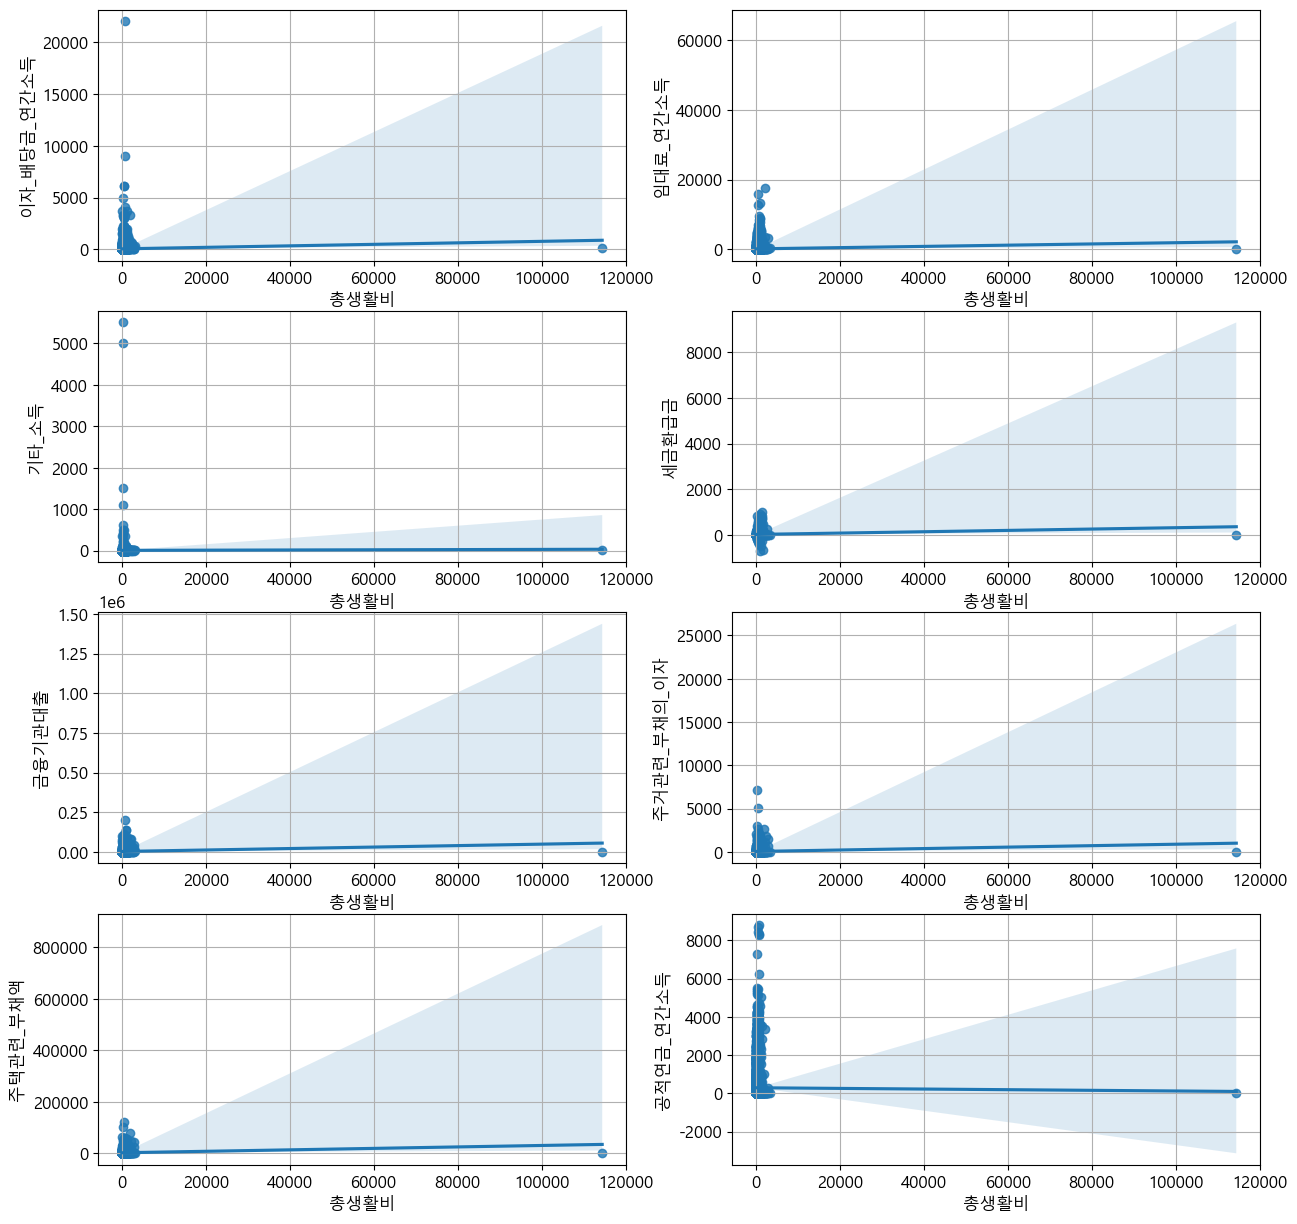

In [13]:
# index = 0부터 시작하면 '총생활비'-'총생활비' 그래프도 그리려고 시도함
columns = list(re_df1.columns)[1:]

# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# 종속변수 설정
dependent_variable = '총생활비'

for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    sb.regplot(data=re_df1, x=dependent_variable, y=c, ax=ax[row, col])
    ax[row, col].set_xlabel(dependent_variable)
    ax[row, col].set_ylabel(c)
    ax[row, col].grid(True)

plt.show()
plt.close()

컬럼 별 이상치 찾기(2)

보기 쉽게 sub plot 및 for문 이용해서 한 번에 boxplot 그래프 조회 

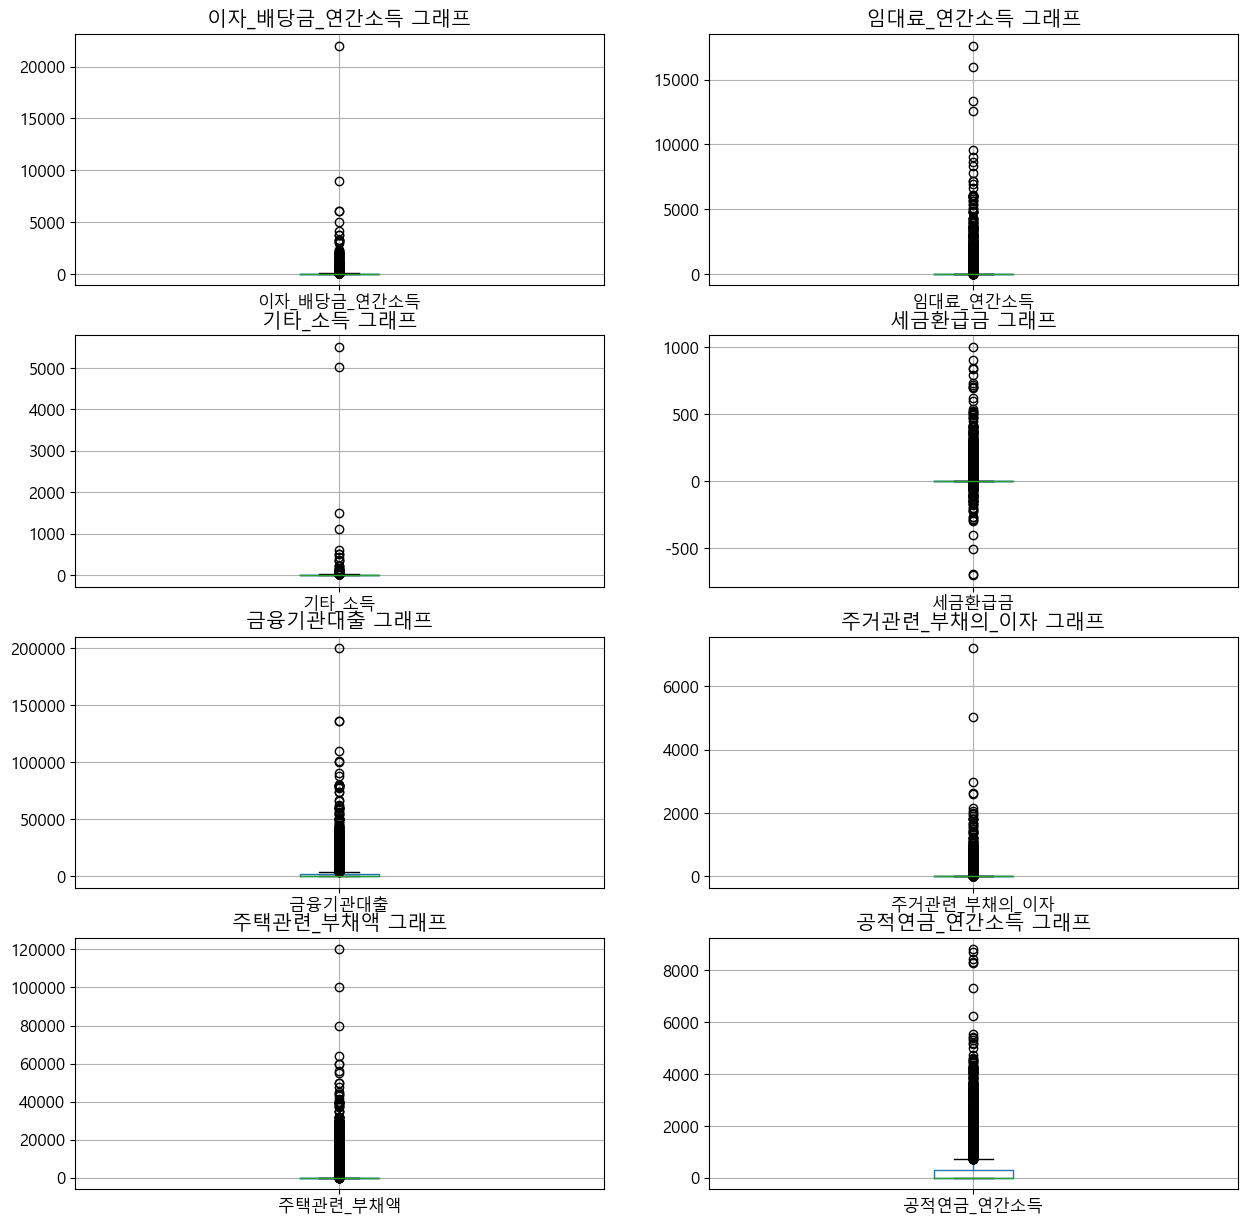

In [14]:
# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    re_df1.boxplot(column=c, ax=ax[row, col])
    ax[row, col].set_title(f"{c} 그래프")
    plt.grid(True)
plt.show()

In [15]:
des_df = df.describe()
des_df

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
count,7865.000000,7865.000000,7865.000000,7865.000000,7865.000000,7865.000000,7865.000000,6786.000000,7865.000000
mean,329.821615,55.537889,129.335537,8.455906,14.505976,2958.797203,53.391736,2055.432508,288.638525
std,1314.994181,347.927318,644.462635,87.829841,59.830654,8277.347380,195.465924,5901.854652,675.030701
min,23.000000,0.000000,0.000000,0.000000,-700.000000,0.000000,0.000000,0.000000,0.000000
25%,121.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,228.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,435.000000,20.000000,0.000000,8.000000,0.000000,1700.000000,0.000000,0.000000,288.000000
max,114446.000000,22025.000000,17640.000000,5506.000000,1000.000000,200000.000000,7200.000000,120000.000000,8796.000000


regplot, boxplot 조회 결과

- x값으로 넣을 종속변수(총생활비)에서 1건만 비정상으로 높은 수치 확인되어 제거하고 진행

- y값으로 넣을 독립변수들 중 이상치가 각 컬럼에서 발견되어 프로젝트 참가자들 주관적 판단에 의해 제거하기로 결정

- 컬럼별 제거 데이터 
     - 이자_배당금_연간소득 상위이상치 2건
     - 임대료_연간소득 상위이상치 4건
     - 기타_소득 상위이상치 4건
     - 주택관련_부채액 상위이상치 3건
     - 공적연금_연간소득 상위이상치 7건
     - 세금환급금 상위이상치 8건
     - 금융기관대출 상위이상치 2건
     - 주거관련_부채의_이자 상위이상치 4건

- 종속변수,독립변수 포함해서 총35건의 데이터 제거하였음

이상치 행 제외 후 데이터 재조회

In [16]:
df2=re_df1.query('(총생활비 < 5000) and (이자_배당금_연간소득 < 7000) and (임대료_연간소득 < 11000) and\
                 (기타_소득 < 1000) and (주택관련_부채액 <75000) and (공적연금_연간소득 <6000) and \
                 (세금환급금 > -500 and 세금환급금 < 750)\
                 and (금융기관대출 < 125000) and (주거관련_부채의_이자 < 2500)')
df2

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


시각화를 통한 이상치 제거 후 데이터 확인

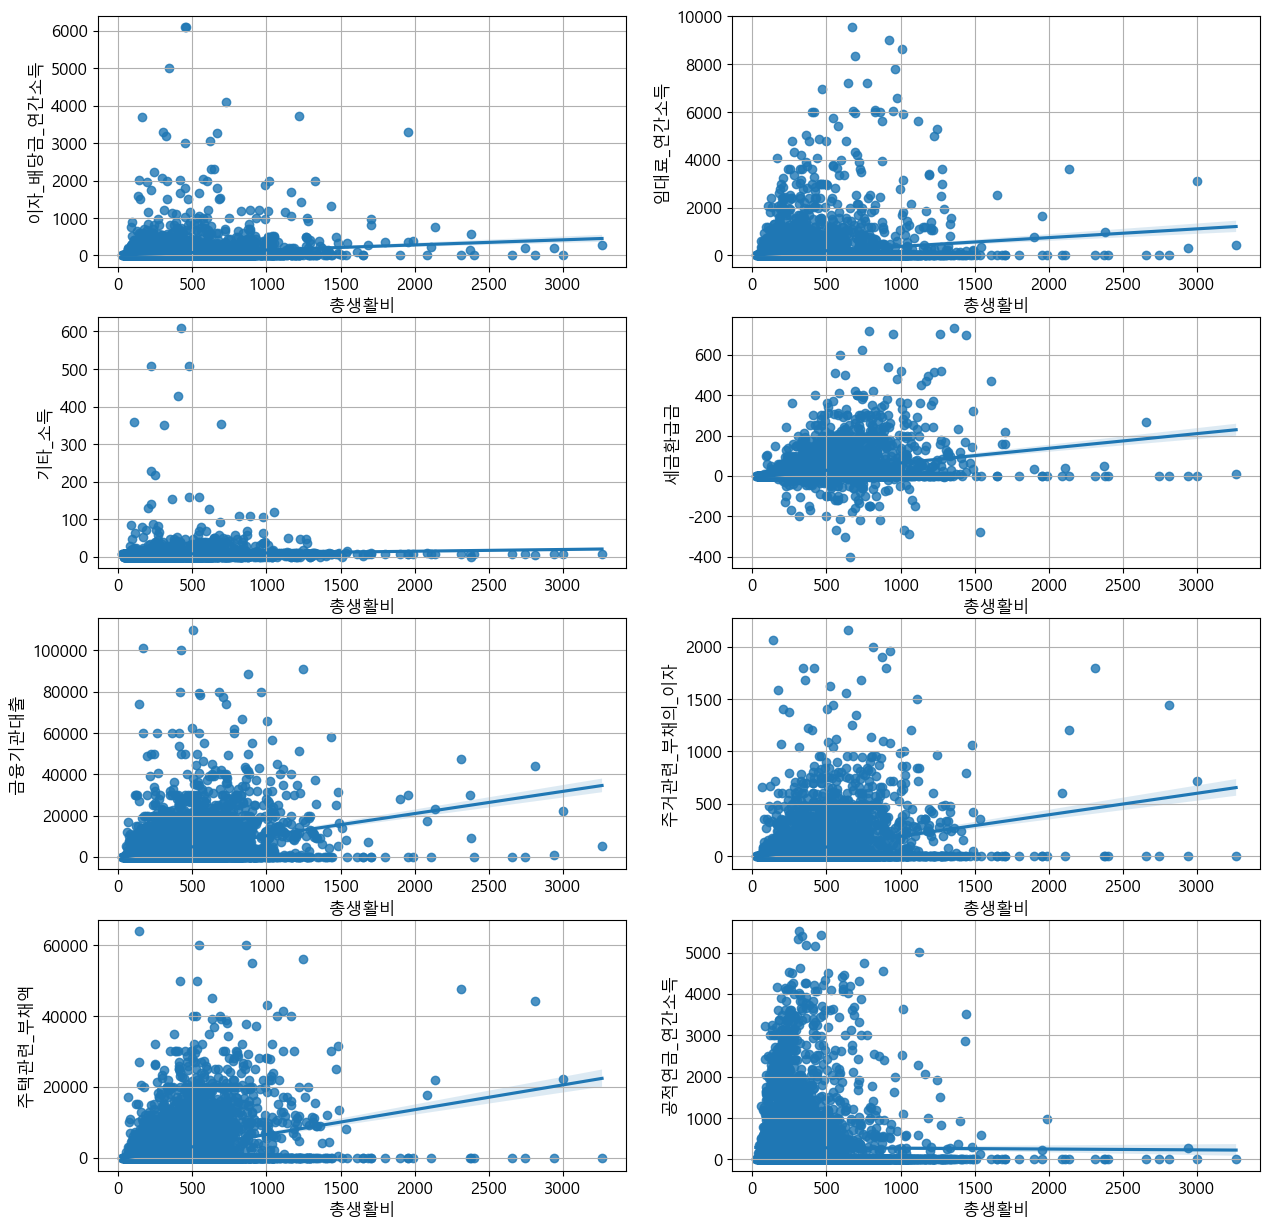

In [17]:
# index = 0부터 시작하면 '총생활비'-'총생활비' 그래프도 그리려고 시도함
columns = list(df2.columns)[1:]

# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# 종속변수 설정
dependent_variable = '총생활비'

for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    sb.regplot(data=df2, x=dependent_variable, y=c, ax=ax[row, col])
    ax[row, col].set_xlabel(dependent_variable)
    ax[row, col].set_ylabel(c)
    ax[row, col].grid(True)

plt.show()
plt.close()

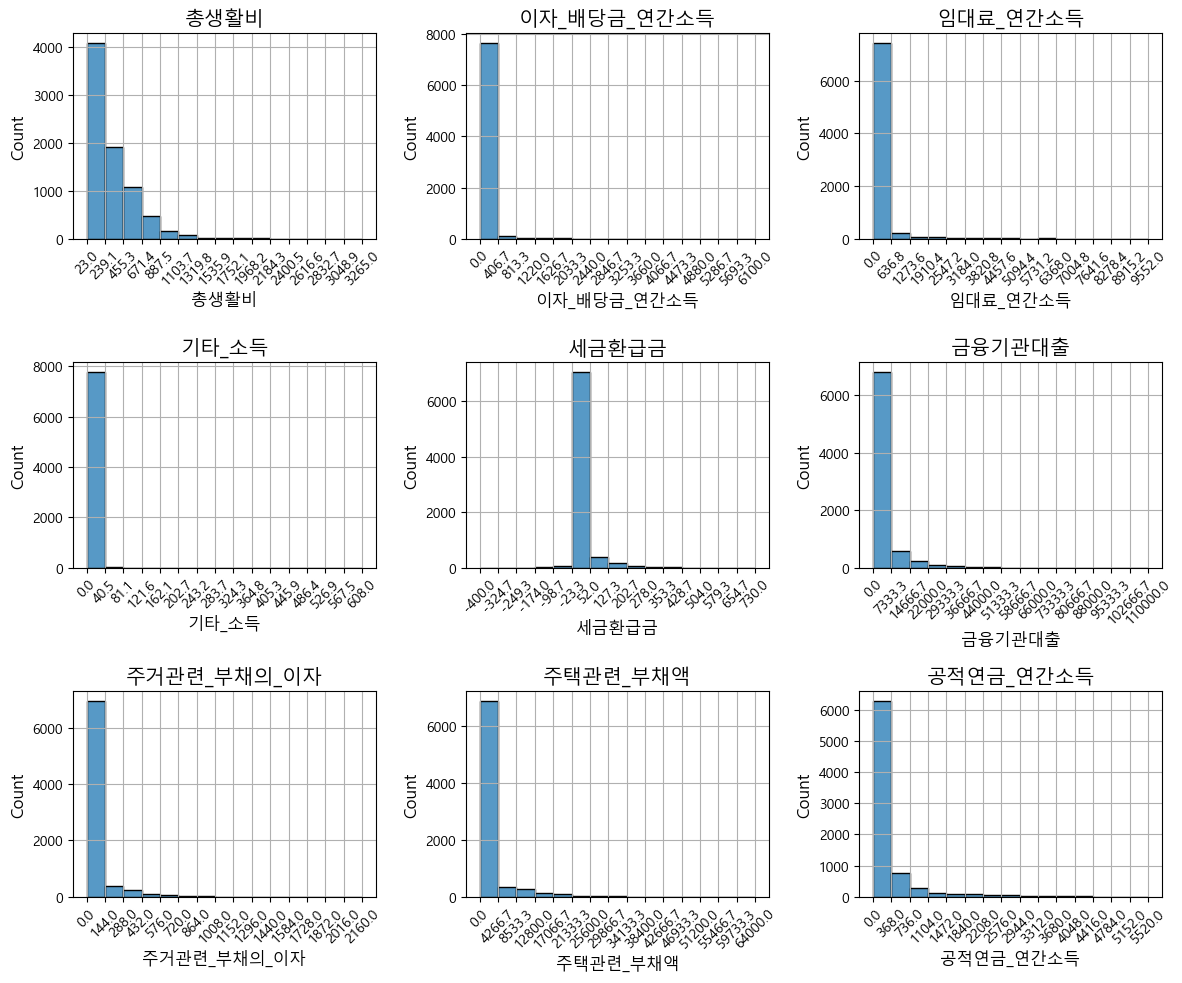

In [18]:
#데이터 분포가 이전보다 나아졌는지 히스토그램 그래프로 재확인

num_bins = 15  # 히스토그램 구간 개수
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))  # 3x3 서브플롯 생성

for ax, column in zip(ax.flat, df2.columns):
    hist, bins = np.histogram(df2[column], bins=num_bins)
    bins2 = np.round(bins, 1)

    sb.histplot(data=df2, x=column, bins=num_bins, kde=False, ax=ax)
    ax.set_title(column)  # 각 subplot의 제목 설정
    ax.set_xticks(bins2)  # x축 눈금 설정
    ax.set_xticklabels(bins2, rotation=45, fontsize=10)  # x축 눈금 라벨 설정 (각도 45도)
    ax.yaxis.set_tick_params(labelsize=10) #y축 폰트 사이즈 설정
    ax.grid(True)

plt.tight_layout()  # 서브플롯 간격 조정
plt.show()

이상치는 어느정도 해결했지만 0에 치우친 값이 상당히 많음을 확인.

결측치를 0으로 상정하고 처리한 만큼 분석에 유의할 것

In [19]:
des_df2 = df2.describe().round(3)
des_df2

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
count,7830.000,7830.000,7830.000,7830.000,7830.000,7830.000,7830.000,7830.000,7830.000
mean,313.272,51.184,121.446,6.765,14.121,2854.026,50.685,1725.766,281.977
std,266.982,222.232,550.526,15.660,54.118,7545.379,160.491,5149.011,634.145
min,23.000,0.000,0.000,0.000,-400.000,0.000,0.000,0.000,0.000
25%,121.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
50%,227.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000,0.000
75%,433.000,20.000,0.000,8.000,0.000,1600.000,0.000,0.000,288.000
max,3265.000,6100.000,9552.000,608.000,730.000,110000.000,2160.000,64000.000,5520.000


피어슨 상관분석 통해 상관계수와 p-value값 확인하기

In [20]:
tmp_df2 = df2.drop('총생활비', axis=1)
# tmp_df2

In [21]:
pearson_r(tmp_df2)

+-------------------------------------------+-------------+-------------+----------+
| fields                                    |   statistic |      pvalue | result   |
|-------------------------------------------+-------------+-------------+----------|
| 이자_배당금_연간소득 vs 임대료_연간소득   |    0.107434 |  1.5335e-21 | True     |
| 임대료_연간소득 vs 기타_소득              |   0.0177123 |    0.117072 | False    |
| 기타_소득 vs 세금환급금                   |   0.0493008 |  1.2744e-05 | True     |
| 세금환급금 vs 금융기관대출                |    0.199542 | 3.86419e-71 | True     |
| 금융기관대출 vs 주거관련_부채의_이자      |    0.667216 |           0 | True     |
| 주거관련_부채의_이자 vs 주택관련_부채액   |    0.847931 |           0 | True     |
| 주택관련_부채액 vs 공적연금_연간소득      |  -0.0758236 | 1.84209e-11 | True     |
| 공적연금_연간소득 vs 이자_배당금_연간소득 |   0.0733512 | 8.11979e-11 | True     |
+-------------------------------------------+-------------+-------------+----------+


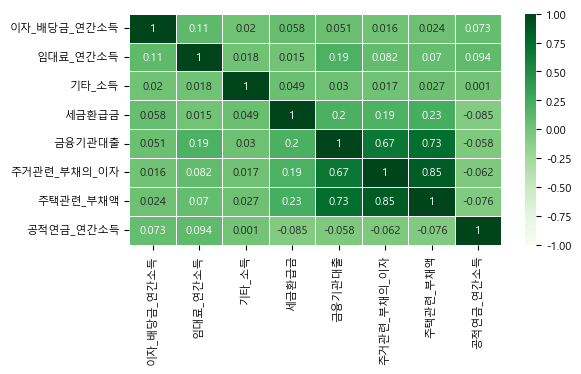

In [22]:
corr = tmp_df2.corr(method='pearson')
plt.rcParams["figure.figsize"] = (6,3)
plt.rcParams['font.size'] = 8
sb.heatmap(tmp_df2.corr(method='pearson'), annot = True, cmap = 'Greens', vmin = -1, vmax=1, linewidths=.5)
plt.show()
plt.close()

In [23]:
spearman_r(tmp_df2)

+-------------------------------------------+-------------+--------------+----------+
| fields                                    |   statistic |       pvalue | result   |
|-------------------------------------------+-------------+--------------+----------|
| 이자_배당금_연간소득 vs 임대료_연간소득   |    0.175408 |  3.87013e-55 | True     |
| 임대료_연간소득 vs 기타_소득              |   0.0982998 |  2.83128e-18 | True     |
| 기타_소득 vs 세금환급금                   |    0.161051 |  1.18817e-46 | True     |
| 세금환급금 vs 금융기관대출                |    0.265976 | 6.49746e-127 | True     |
| 금융기관대출 vs 주거관련_부채의_이자      |    0.741786 |            0 | True     |
| 주거관련_부채의_이자 vs 주택관련_부채액   |    0.931587 |            0 | True     |
| 주택관련_부채액 vs 공적연금_연간소득      |   -0.190382 |  8.29779e-65 | True     |
| 공적연금_연간소득 vs 이자_배당금_연간소득 |    0.223224 |  5.27069e-89 | True     |
+-------------------------------------------+-------------+--------------+----------+


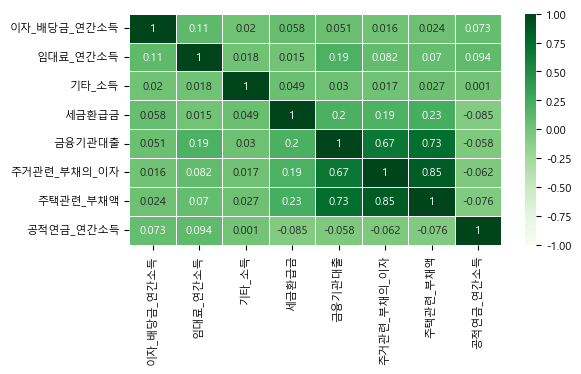

In [24]:
corr = tmp_df2.corr(method='spearman')
plt.rcParams["figure.figsize"] = (6,3)
plt.rcParams['font.size'] = 8
sb.heatmap(tmp_df2.corr(method='pearson'), annot = True, cmap = 'Greens', vmin = -1, vmax=1, linewidths=.5)
plt.show()
plt.close()

상관계수 행렬 생성 후 산점도 행렬 시각화

그래프와 피어슨 상관분석을 바탕으로 총생활비(=소비금액) 금액이 커질수록 불로소득(이자_배당금_연간소득, 임대료_연간소득, 세금환급금)이 `양의 상관관계`를 가진다고 예측할 수 있다.

다만, `공적연금_연간소득`과는 상관관계가 크지 않다고 판단이 된다.

# #전처리2. 정규성/등분산성/독립성 확인

비모수적인 방법 사용, 로버스트(robust) 통계 기법 사용, 대규모 데이터셋 사용, 통계 기법과 목적에 따른 유연성(회귀분석의 예측 모델링이 목적)에 따라 정규성/등분산성/독립성 확인을 제외

현재 대규모 데이터셋을 사용하기 때문에 정규성, 등분산성, 독립성 확인은 제외하기로 결정

#선형회귀->정규분포 가정으로 대체를 해야하는지 확인해보기

신뢰구간

In [25]:
# 정규화 하기 전 각 컬럼의 신뢰구간 구하기

df2Col = list(df2.columns)
# df2Col
for cc in df2Col:
    print("%s 신뢰구간"%cc)
    getConfidenceInterval(df2["%s"%cc])
    # print('\n')

총생활비 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    307.358 |
| 상한 |    319.187 |
+------+------------+
이자_배당금_연간소득 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    46.2607 |
| 상한 |     56.107 |
+------+------------+
임대료_연간소득 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |     109.25 |
| 상한 |    133.642 |
+------+------------+
기타_소득 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    6.41806 |
| 상한 |    7.11188 |
+------+------------+
세금환급금 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    12.9223 |
| 상한 |      15.32 |
+------+------------+
금융기관대출 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    2686.87 |
| 상한 |    3021.18 |
+------+------------+
주거관련_부채의_이자 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    47.1293 |
| 상한 |    54.2401 |
+------+------------+
주택관련_부채액 신뢰구간
+------+------------+
|   

In [61]:
# # 신뢰수준
# clevel = 0.95

# # 샘플 사이즈
# n = len(df['총생활비'])
# # 자유도
# dof = n - 1
# # 평균
# sample_mean = df2['총생활비'].mean()
# # 표본 표준 편차
# sample_std = df2['총생활비'].std(ddof=1)
# # 표본 표준오차
# sample_std_error = sample_std / sqrt(n)
# # 신뢰구간
# cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

# sb.kdeplot(data=df2, x='총생활비')
# # 신뢰구간 min 설정
# sb.lineplot(x=[cmin, cmax], y=[0,0.1], color='red')
# # 신뢰구간 max 설정
# sb.lineplot(x=[cmax, cmin], y=[0,0.1], color='blue')
# # -> 붉은선, 파란선 구간이 신뢰 구간 95% 지점
# plt.xlim(-20, 500)
# plt.ylim(0, 0.01)
# plt.show()
# plt.close()

# #전처리3. 표준화-정규화(Scaling)

표준화(정규화)를 통해 서로 다른 단위나 범위를 가진 데이터를 동일한 기준으로 맞춤으로써, 데이터 분석이나 머신러닝 모델의 성능을 향상.

다만, 현재 사용중인 데이터에는 명목형(범주형)변수를 제외한 경우인 만큼 더미변수화 시킬 필요가 없다고 판단, 스케일링만 진행하기로 결정.

시간이 된다면 (표준화 적용한 결과/표준화를 적용하지 않은 결과의 차이를 비교, 학습)

데이터 정규화하기

In [62]:
scaler=StandardScaler()
df_std = df2.copy()

df_std['총생활비'] = scaler.fit_transform(df_std[['총생활비']])
df_std['이자_배당금_연간소득'] = scaler.fit_transform(df_std[['이자_배당금_연간소득']])
df_std['임대료_연간소득'] = scaler.fit_transform(df_std[['임대료_연간소득']])
df_std['기타_소득'] = scaler.fit_transform(df_std[['기타_소득']])
df_std['세금환급금'] = scaler.fit_transform(df_std[['세금환급금']])
df_std['금융기관대출'] = scaler.fit_transform(df_std[['금융기관대출']])
df_std['주거관련_부채의_이자'] = scaler.fit_transform(df_std[['주거관련_부채의_이자']])
df_std['주택관련_부채액'] = scaler.fit_transform(df_std[['주택관련_부채액']])
df_std['공적연금_연간소득'] = scaler.fit_transform(df_std[['공적연금_연간소득']])
df_std

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,-0.143361,-0.230332,-0.220614,0.015010,-0.260949,0.947127,-0.315830,-0.335186,-0.444685
1,-0.278210,-0.230332,-0.220614,0.015010,-0.260949,-0.378272,-0.315830,-0.335186,-0.444685
2,-0.589112,-0.230332,-0.075289,0.015010,-0.260949,1.477286,4.170679,3.646416,0.406910
3,0.853023,0.399681,-0.220614,0.142735,-0.260949,-0.378272,-0.315830,-0.335186,-0.444685
4,-0.855064,-0.005327,-0.220614,0.015010,-0.260949,-0.378272,-0.315830,-0.335186,-0.444685
...,...,...,...,...,...,...,...,...,...
7860,0.264932,-0.230332,-0.220614,-0.368166,1.032604,0.019347,0.282372,0.247487,-0.444685
7861,1.504793,-0.230332,0.978317,-0.368166,1.402191,4.923324,-0.315830,-0.335186,-0.444685
7862,1.055296,-0.230332,7.045634,-0.368166,-0.260949,3.060741,0.101665,4.704356,-0.444685
7863,0.931685,-0.050328,-0.220614,-0.432028,-0.260949,1.212207,1.927425,1.995508,-0.444685


회귀분석 전 PCA 분석

In [63]:
# 독립변수 추출(이미 스케일링 된 DF)
x_train_std = df_std.drop("총생활비", axis=1)
x_train_std

,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,-0.230332,-0.220614,0.015010,-0.260949,0.947127,-0.315830,-0.335186,-0.444685
1,-0.230332,-0.220614,0.015010,-0.260949,-0.378272,-0.315830,-0.335186,-0.444685
2,-0.230332,-0.075289,0.015010,-0.260949,1.477286,4.170679,3.646416,0.406910
3,0.399681,-0.220614,0.142735,-0.260949,-0.378272,-0.315830,-0.335186,-0.444685
4,-0.005327,-0.220614,0.015010,-0.260949,-0.378272,-0.315830,-0.335186,-0.444685
...,...,...,...,...,...,...,...,...
7860,-0.230332,-0.220614,-0.368166,1.032604,0.019347,0.282372,0.247487,-0.444685
7861,-0.230332,0.978317,-0.368166,1.402191,4.923324,-0.315830,-0.335186,-0.444685
7862,-0.230332,7.045634,-0.368166,-0.260949,3.060741,0.101665,4.704356,-0.444685
7863,-0.050328,-0.220614,-0.432028,-0.260949,1.212207,1.927425,1.995508,-0.444685


PCA 패키지를 사용한 분석

In [64]:
# 주성분 분석의 대상 컬럼 수를 독립변수의 전체 컬럼의 길이로 설정
model = pca(n_components=len(x_train_std.columns))
# 표준화 결과를 활용하여 주성분 분석 수행
fit = model.fit_transform(x_train_std)
fit

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [8] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[8]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


{'loadings':      이자_배당금_연간소득  임대료_연간소득     기타_소득     세금환급금    금융기관대출  주거관련_부채의_이자  \
 PC1     0.043825  0.117035  0.033994  0.221289  0.535173     0.558892   
 PC2     0.540629  0.597150  0.085741 -0.091797  0.054843    -0.053280   
 PC3     0.305079 -0.069816  0.740267  0.508716 -0.082120    -0.118516   
 PC4    -0.536590  0.039389  0.649855 -0.421792  0.056258     0.080143   
 PC5    -0.244294  0.747407 -0.000591 -0.086602  0.044140    -0.106836   
 PC6     0.514516 -0.205376  0.145137 -0.705589  0.054911     0.088063   
 PC7    -0.019434 -0.146466 -0.009216 -0.010510  0.819157    -0.499728   
 PC8     0.003738 -0.032253  0.005997  0.020927  0.157137     0.628836   
 
      주택관련_부채액  공적연금_연간소득  
 PC1  0.574913  -0.070447  
 PC2 -0.061838   0.570687  
 PC3 -0.088596  -0.258120  
 PC4  0.064604   0.310706  
 PC5 -0.109757  -0.590588  
 PC6  0.080324  -0.396171  
 PC7 -0.238374   0.020156  
 PC8 -0.760465  -0.006121  ,
 'PC':            PC1       PC2       PC3       PC4       PC5      

필드 확인

In [65]:
topfit = fit['topfeat']
topfit

,PC,feature,loading,type
0,PC1,주택관련_부채액,0.574913,best
1,PC2,임대료_연간소득,0.597150,best
2,PC3,기타_소득,0.740267,best
3,PC4,기타_소득,0.649855,best
4,PC5,임대료_연간소득,0.747407,best
5,PC6,세금환급금,-0.705589,best
6,PC7,금융기관대출,0.819157,best
7,PC8,주택관련_부채액,-0.760465,best
8,PC2,이자_배당금_연간소득,0.540629,weak
9,PC8,주거관련_부채의_이자,0.628836,weak


주성분 분석 결과를 토대로 회귀분석 수행

In [66]:
best = topfit.query("type=='best'")
feature = list(set(list(best['feature'])))
print(feature)

['임대료_연간소득', '주택관련_부채액', '금융기관대출', '세금환급금', '기타_소득']


In [67]:
df2.columns[0]

'총생활비'

In [68]:
ols = myOls(df2, "총생활비", feature)
ols.summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   총생활비   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     534.0
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        17:12:44   Log-Likelihood:                -53708.
No. Observations:                7830   AIC:                         1.074e+05
Df Residuals:                    7824   BIC:                         1.075e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    247.4640      3.060     80.876      0.000     241.466     253.462
임대료_연간소득       0.0615      0.005     12.687      0.000       0.052       0.071
주택관련_부채액       0.0079      0.001     10.545      0.000       0.006       0.009
금융기관대출         0.0067      0.001     12.951      0.000       0.006       0.008
세금환급금          1.3911      0.050     28.069      0.000       1.294       1.488
기타_소득          0.9041      0.167      5.424      0.000       0.577       1.231
==============================================================================
Omnibus:                     4881.896   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100359.478
Skew:                           2.630   Prob(JB):                         0.00
Kurtosis:                      19.731   Cond. No.                     1.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
ols.table

B   표준오차  β        t   유의확률       VIF
종속변수 독립변수                                                
총생활비 임대료_연간소득  0.0615  0.005  0  12.687*  0.000  1.137131
     주택관련_부채액  0.0079  0.001  0  10.545*  0.000  4.832777
     금융기관대출    0.0067  0.001  0  12.951*  0.000  2.631621
     세금환급금     1.3911  0.050  0  28.069*  0.000  1.244113
     기타_소득     0.9041  0.167  0   5.424*  0.000  1.143680